## Import and old part


In [1]:
# Import general libraries
import cv2
import numpy as np

In [2]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits

img_path = 'dataset/hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)

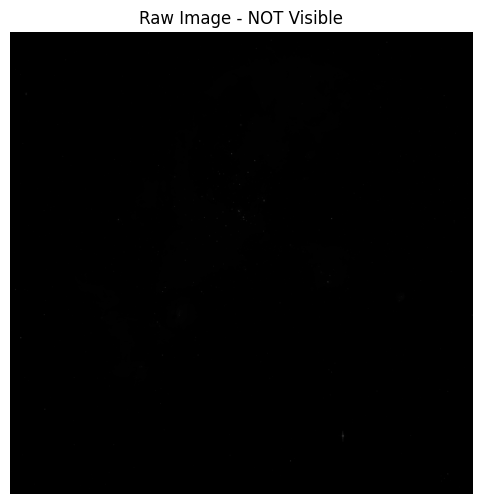

In [3]:
# Simple image plot
# Just to show that a transormation is needed to display the image
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))
plt.imshow(raw_img, cmap='gray')
plt.title('Raw Image - NOT Visible')
plt.axis('off')
plt.show()

In [4]:
# Using auto_stretch library to visualize the image
from auto_stretch import apply_stretch

stretched_img = apply_stretch(raw_img)

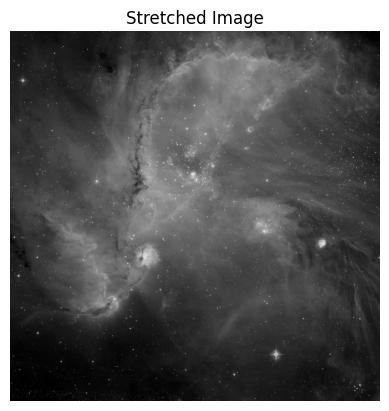

In [5]:
# Plot stretched image
plt.imshow(stretched_img, cmap='gray')
plt.title('Stretched Image')
plt.axis('off')
plt.show()

Text(0.5, 1.0, 'Arcsinh Stretched Image')

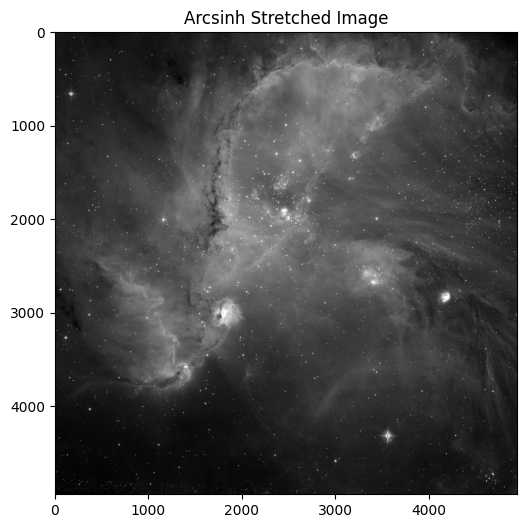

In [6]:
# arcsinh stretch

def arcsinh_stretch(image, beta, min_percent=0.1, max_percent=99.9):
    """
    Apply arcsinh stretch to the image.
    """
    # Calculate the percentiles for stretching
    p_min = np.percentile(image, min_percent)
    p_max = np.percentile(image, max_percent)

    # Normalize the image to the range [0, 1]
    norm_image = (image - p_min) / (p_max - p_min)
    norm_image = np.clip(norm_image, 0, 1)

    # Apply arcsinh stretch
    stretched_image = np.arcsinh(norm_image * beta) / np.arcsinh(beta)

    return stretched_image


stretched_img_arcsinh = arcsinh_stretch(raw_img, 10)
plt.figure(figsize=(12, 6))
plt.imshow(stretched_img_arcsinh, cmap='gray')
plt.title('Arcsinh Stretched Image')

In [7]:
def float32_to_uint8(float_img):
    """
    Convert a float32 image to uint8 format.
    
    Parameters:
    - float_img: np.float32 array, input image
    
    Returns:
    - np.uint8 array, output image with values in range 0-255
    """
    # Check the current range of the image
    min_val = float_img.min()
    max_val = float_img.max()
    
    # Method 1: Simple scaling (for images already in 0-1 range)
    if 0 <= min_val and max_val <= 1:
        uint8_img = (float_img * 255).clip(0, 255).astype(np.uint8)

        
    
    # Method 2: Full normalization (for images with arbitrary ranges)
    else:
        # Normalize to 0-1 range first
        normalized_img = (float_img - min_val) / (max_val - min_val)
        # Then scale to 0-255
        uint8_img = (normalized_img * 255).clip(0, 255).astype(np.uint8)
    
    return uint8_img



In [8]:
def diff_img(image0, image1):
    diff = cv2.absdiff(image0, image1)
    return diff

## New part

In [9]:
stretched_img_uint = float32_to_uint8(stretched_img)
cv2.imwrite('./output_images/original_image.png', stretched_img_uint)


True

In [10]:
def use_blob_detector(name, original_image, params, smoothing_params = None):
    """
    Use a blob detector to find and mask stars in an image.
    
    Parameters:
    - name: str, name of the image for saving output
    - original_image: np.array, the original image
    - params: cv2.SimpleBlobDetector_Params, parameters for the blob detector
    - smooth: int, smoothing factor for Gaussian blur
    
    Returns:
    - mask: np.array, binary mask of detected stars
    """
    
    # Convert to grayscale if not already
    if len(original_image.shape) == 3:
        img_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = original_image

    # Apply Gaussian blur to reduce noise
    if smoothing_params is not None:
        blur = cv2.GaussianBlur(img_gray, (smoothing_params["kernel_size"], smoothing_params["kernel_size"]), smoothing_params["sigma"])
    else:
        blur = img_gray

    # Create the blob detector with the specified parameters
    detector = cv2.SimpleBlobDetector_create(params)

    # Detect blobs (stars)
    keypoints = detector.detect(blur)

    img_con_punti = cv2.drawKeypoints(
    original_image, keypoints, np.array([]), (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
    
    cv2.imwrite(f'./output_images/{name}_blob_keypoints.png', img_con_punti)

    # Create a mask for the detected blobs
    mask = np.zeros(img_gray.shape, dtype=np.uint8)
    
    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
        r = int(kp.size / 2)                      # estimated radius of the blob
        cv2.circle(mask, (x, y), r, 255, thickness=-1)  # draw blob in the mask

    cv2.imwrite(f'./output_images/{name}_mask.png', mask)

    return mask, keypoints

Super small stars

In [11]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 30
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 3     # evita pixel singoli o rumore
params.maxArea = 20   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = False
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = False
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = None

mask1_xs, kp_xs = use_blob_detector('m1_xs', stretched_img_uint, params, smoothing_params)

small stars

In [12]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 70
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 20     # evita pixel singoli o rumore
params.maxArea = 100   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 3,  # Size of the Gaussian kernel
    "sigma": 0.5       # Standard deviation for Gaussian kernel
}

mask2_sm, kp_sm = use_blob_detector('m2_s', stretched_img_uint, params, smoothing_params)

Medium

In [13]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 50
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 70     # evita pixel singoli o rumore
params.maxArea = 500   # evita blob grandi come galassie

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.85  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.85  # più vicino a 1 = più convesso
params.filterByInertia = False      # per la simmetria, si potrebbe usare

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 5,  # Size of the Gaussian kernel
    "sigma": 0       # Standard deviation for Gaussian kernel
}

mask3_m, kp_m = use_blob_detector('m3_m', stretched_img_uint, params, smoothing_params)

Large stars

In [14]:
# Imposta i parametri del detector
params = cv2.SimpleBlobDetector_Params()

params.minThreshold = 100
params.maxThreshold = 255
params.thresholdStep = 5

# Filtro per area (modifica questi se rileva troppo)
params.filterByArea = True
params.minArea = 400     
params.maxArea = 3000  

# Filtro per circolarità
params.filterByCircularity = True
params.minCircularity = 0.8  # più vicino a 1 = più circolare

params.filterByConvexity = True
params.minConvexity = 0.8  # più vicino a 1 = più convesso
params.filterByInertia = True
params.minInertiaRatio = 0.8  # più vicino a 1 = più simmetrico

# Cerca solo blob chiari su sfondo scuro
params.filterByColor = True
params.blobColor = 255
smoothing_params = {
    "kernel_size": 7,  # Size of the Gaussian kernel
    "sigma": 1.5       # Standard deviation for Gaussian kernel
}

mask4_l, kp_l = use_blob_detector('m4_l', stretched_img_uint, params, smoothing_params)

In [15]:
merged_mask = cv2.bitwise_or(mask1_xs, mask2_sm)
merged_mask = cv2.bitwise_or(merged_mask, mask3_m)
merged_mask = cv2.bitwise_or(merged_mask, mask4_l)
cv2.imwrite('./output_images/merged_mask.png', merged_mask)
stretched_img_wo_stars = stretched_img_uint.copy()
stretched_img_wo_stars[merged_mask == 255] = 0
cv2.imwrite('./output_images/stretched_wo_stars_m1234.png', stretched_img_wo_stars)

True

In [16]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
mask1_dilated = cv2.dilate(mask1_xs, kernel1, iterations=2)
mask2_dilated = cv2.dilate(mask2_sm, kernel1, iterations=3)
mask3_dilated = cv2.dilate(mask3_m, kernel1, iterations=4)
mask4_dilated = cv2.dilate(mask4_l, kernel1, iterations=4)

merged_mask_dilated = cv2.bitwise_or(mask1_dilated, mask2_dilated)
merged_mask_dilated = cv2.bitwise_or(merged_mask_dilated, mask3_dilated)
merged_mask_dilated = cv2.bitwise_or(merged_mask_dilated, mask4_dilated)
cv2.imwrite('./output_images/merged_mask_dilated.png', merged_mask_dilated)
stretched_img_wo_stars_dilated = stretched_img_uint.copy()
stretched_img_wo_stars_dilated[merged_mask_dilated == 255] = 0
cv2.imwrite('./output_images/stretched_wo_stars_dilated_1234.png', stretched_img_wo_stars_dilated)


True

In [59]:
# Perform inpainting to remove stars using the merged mask
inpainted_image = cv2.inpaint(stretched_img_uint, merged_mask_dilated, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Save the inpainted image
cv2.imwrite('./output_images/i2_inpainted_image.png', inpainted_image)

True

### New method for inpainting

In [21]:
import math

def calculate_median_circle(image, cx, cy, radius, channels):
        """
        Calculate the median value of a circle for the specified channels.

        Args:
            image (np.ndarray): The image array.
            cx (int): X-coordinate of the circle center.
            cy (int): Y-coordinate of the circle center.
            radius (int): Radius of the circle.
            channels (list): List of channel indices to process.

        Returns:
            float: The overall median value across specified channels.
        """
        values = []
        for c in channels:
            y_min = max(cy - radius, 0)
            y_max = min(cy + radius + 1, image.shape[0])
            x_min = max(cx - radius, 0)
            x_max = min(cx + radius + 1, image.shape[1])

            if image.ndim == 2:
                # Grayscale image (2D)
                roi = image[y_min:y_max, x_min:x_max]
            elif image.ndim == 3:
                if image.shape[2] ==1:
                    # Grayscale image with single channel
                    roi = image[y_min:y_max, x_min:x_max, 0]
                elif image.shape[2] >= c+1:
                    # RGB image
                    roi = image[y_min:y_max, x_min:x_max, c]
                else:
                    continue  # Skip if channel is out of bounds
            else:
                continue  # Unsupported image dimensions

            yy, xx = np.ogrid[:roi.shape[0], :roi.shape[1]]
            dist_from_center = np.sqrt((xx - (cx - x_min))**2 + (yy - (cy - y_min))**2)
            mask = dist_from_center <= radius
            values.extend(roi[mask].flatten())

        return np.median(values) if values else 0.0

def remove_blemish(image, x, y, radius, feather, opacity, channels_to_process):
    """
    Perform per-pixel blemish removal by sampling from surrounding circles.
    Handles edge cases where correction circles may extend beyond image boundaries.
    """
    corrected_image = image.copy()
    h, w = image.shape[:2]

    # Define angles for surrounding circles
    angles = [0, 60, 120, 180, 240, 300]
    surrounding_centers = []
    for angle in angles:
        rad = math.radians(angle)
        dx = int(math.cos(rad) * (radius * 1.5))  # 1.5 times the radius away
        dy = int(math.sin(rad) * (radius * 1.5))
        surrounding_centers.append((x + dx, y + dy))

    # Calculate medians for each surrounding circle and the target circle
    target_median = calculate_median_circle(image, x, y, radius, channels_to_process)
    surrounding_medians = [
        calculate_median_circle(image, cx, cy, radius, channels_to_process)
        for cx, cy in surrounding_centers
    ]

    # Determine the three correction circles closest to the target median
    median_diffs = [abs(median - target_median) for median in surrounding_medians]
    closest_indices = np.argsort(median_diffs)[:3]  # Indices of the three closest circles
    selected_circles = [surrounding_centers[i] for i in closest_indices]

    # Iterate through each channel
    for c in channels_to_process:
        # Iterate through each pixel in the target blemish circle
        for i in range(max(y - radius, 0), min(y + radius + 1, h)):
            for j in range(max(x - radius, 0), min(x + radius + 1, w)):
                dist = math.sqrt((j - x) ** 2 + (i - y) ** 2)
                if dist <= radius:
                    # Apply feathering based on distance
                    if feather > 0:
                        weight = max(0, min(1, (radius - dist) / (radius * feather)))
                    else:
                        weight = 1

                    # Collect corresponding pixel values from the selected correction circles
                    sampled_values = []
                    for (cx, cy) in selected_circles:
                        # Find the corresponding pixel position
                        corresponding_j = j + (cx - x)
                        corresponding_i = i + (cy - y)

                        # Ensure the corresponding pixel is within image bounds
                        if 0 <= corresponding_i < h and 0 <= corresponding_j < w:
                            if image.ndim == 2:
                                sampled_values.append(image[corresponding_i, corresponding_j])
                            elif image.ndim == 3:
                                if image.shape[2] == 1:
                                    sampled_values.append(image[corresponding_i, corresponding_j, 0])
                                elif image.shape[2] > c:
                                    sampled_values.append(image[corresponding_i, corresponding_j, c])
                                else:
                                    continue  # Skip if channel is out of bounds

                    if sampled_values:
                        # Calculate the median of the sampled values
                        median_val = np.median(sampled_values)
                    else:
                        # If no valid sampled pixels, retain the original pixel value
                        if image.ndim == 2:
                            median_val = image[i, j]
                        elif image.ndim == 3 and image.shape[2] ==1:
                            median_val = image[i, j,0]
                        else:
                            median_val = image[i,j,c]

                    # Blend the median value into the target pixel using opacity and feathering
                    if image.ndim ==2:
                        original_val = image[i, j]
                        blended_val = (1 - opacity * weight) * original_val + (opacity * weight) * median_val
                        corrected_image[i, j] = blended_val
                    elif image.ndim ==3 and image.shape[2] ==1:
                        original_val = image[i, j,0]
                        blended_val = (1 - opacity * weight) * original_val + (opacity * weight) * median_val
                        corrected_image[i, j,0] = blended_val
                    elif image.ndim ==3 and image.shape[2] >c:
                        original_val = image[i, j, c]
                        blended_val = (1 - opacity * weight) * original_val + (opacity * weight) * median_val
                        corrected_image[i, j, c] = blended_val

    return corrected_image

In [22]:
big_star_inpainted_r = remove_blemish(image=stretched_img, x=4686, y=668, radius=135, feather=0.5, opacity=1, channels_to_process=[0])

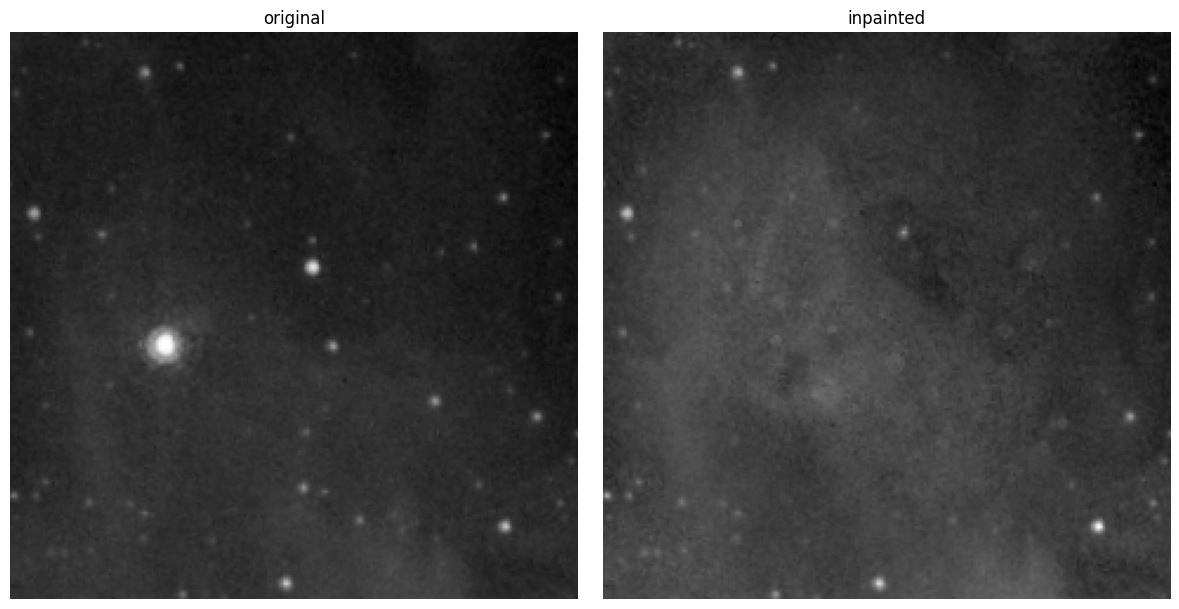

In [23]:
# Show result
half_size = 120
x, y = 4686, 668

patch_original = stretched_img[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]
patch_r = big_star_inpainted_r[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]

# patch_inpainted = small_star_inpainted[y - half_size : y + half_size + 1,
#               x - half_size : x + half_size + 1]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 
axes[0].imshow(patch_original, cmap='gray')
axes[0].set_title('original')
axes[0].axis('off')

# 
axes[1].imshow(patch_r, cmap='gray')
axes[1].set_title('inpainted')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [34]:
res = stretched_img_uint.copy()
for kp in kp_xs:
    x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
    r = int(kp.size / 2) + 4                     # estimated radius of the blob
    res = remove_blemish(res, x, y, r, feather=0.5, opacity=1, channels_to_process=[0])
for kp in kp_sm:
    x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
    r = int(kp.size / 2) + 8                     # estimated radius of the blob
    res = remove_blemish(res, x, y, r, feather=0.5, opacity=1, channels_to_process=[0])
for kp in kp_m:
    x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
    r = int(kp.size / 2) + 15                     # estimated radius of the blob
    res = remove_blemish(res, x, y, r, feather=0.5, opacity=1, channels_to_process=[0])
for kp in kp_l:
    x, y = int(kp.pt[0]), int(kp.pt[1])       # coordinates of the center
    r = int(kp.size / 2) + 15                     # estimated radius of the blob
    res = remove_blemish(res, x, y, r, feather=0.5, opacity=1, channels_to_process=[0])



In [35]:
cv2.imwrite('./output_images/provinho.png', res)

True